Here we do the final processing required for the model inputs.

# Setup

In [26]:
#| default_exp final.process

In [27]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [28]:
#| export
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

from recipe_dataset.utils.parallel import parallel_apply


In [29]:
food_ids = pd.read_feather(f'{root}/../data/local/molecule/partial/food_ids/1_na_filled.feather')
food_df = pd.read_feather(f'{root}/../data/local/molecule/full/food/2_feature_engineered.feather')
food_embeddings = pd.read_feather(f'{root}/../data/local/molecule/full/food_compounds/0.feather')

food_ids = food_ids.astype('Int64')
food_embeddings = food_embeddings.astype('float')

In [30]:
#| export
special_tokens = ['pad', 'mask', 'unknown', 'end']

# #TODO Only Zeros

There's an issue here with our embeddings. There are a number of embeddings which contain only zeros.

In [31]:
nonzeros = (food_embeddings > 0).sum(1)
np.argwhere(nonzeros == 0)

array([[ 143],
       [ 150],
       [ 262],
       [ 287],
       [1064]])

In [32]:
food_df['name'].iloc[np.where(nonzeros == 0)[0]]

id
143            dried lemon balm
150            dried peppermint
262     dried lowbush blueberry
287                dried ginger
1064           dried blackberry
Name: name, dtype: string

We can manually replace these 

In [33]:
food_df['name'][food_df['name'].str.contains('blackberry')]

id
1063          blackberry
1064    dried blackberry
Name: name, dtype: string

In [34]:
#| export
temp_remap = {
    143: 142,
    150: 149,
    262: 261,
    1064: 1063
}

Lets set these to the mean temporarily until we redo the model.

# Foods

Here we already have our food compounds in a dataframe. All that is left to do is:

- Converting to numpy (efficiency)
- Adding special tokens for masked modelling

We want to do this for two pieces of data - that containing the names of the foods, and also that containing the embedding vectors.

## Food Names

Mapping food indexes to their names.

In [35]:
food_names = food_df['name'].to_numpy().astype(str)
food_names

array(['angelica', 'kiwi', 'allium', ..., 'fish oil', 'taco shell',
       'tostada shell'], dtype='<U41')

In [36]:
special_token_names = np.array([f'<{t}>' for t in special_tokens])
special_token_names, special_token_names.shape

(array(['<pad>', '<mask>', '<unknown>', '<end>'], dtype='<U9'), (4,))

In [37]:
food_names = np.append(special_token_names, food_names, axis=0)
food_names.shape

(1110,)

## Food Embeddings

Mapping food indexes to their embedding vectors.

In [38]:
food_embeddings = food_embeddings.to_numpy()

Since molecules have varying scales for their potency, and their concentration in ingredients, we need to scale this data.

We don't want to change the distribution of the features, as this would change the values calculated by their concentration. All that needs to be done is scaled their values so the model doesn't bias towards molecules with naturally higher concentrations.

### Rescaling

In order for our model to weigh the compound concentrations independently of their scale of them we want to rescale them equally ((-1,1) is standard for embeddings).

In [39]:
max_values = food_embeddings.max(axis=0)
min_values = food_embeddings.min(axis=0)

print(np.where(max_values == min_values))

(array([ 27,  28,  30, 127, 149, 156, 201, 245]),)


In [40]:
food_embeddings[:,np.where(max_values == min_values)[0]]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

-> simply all zeros

In [41]:
food_embeddings = food_embeddings[:,np.where(max_values != min_values)[0]]
food_embeddings.shape

(1106, 400)

In [42]:
def rescale(array, min, max):
    max_values = array.max(axis=0)
    min_values = array.min(axis=0)
    scaled = ((array - min_values) / (max_values - min_values)) * (max - min) + min
    return scaled

rescaled = rescale(food_embeddings, -1, 1)

In [43]:
np.isnan(rescaled).sum()

0

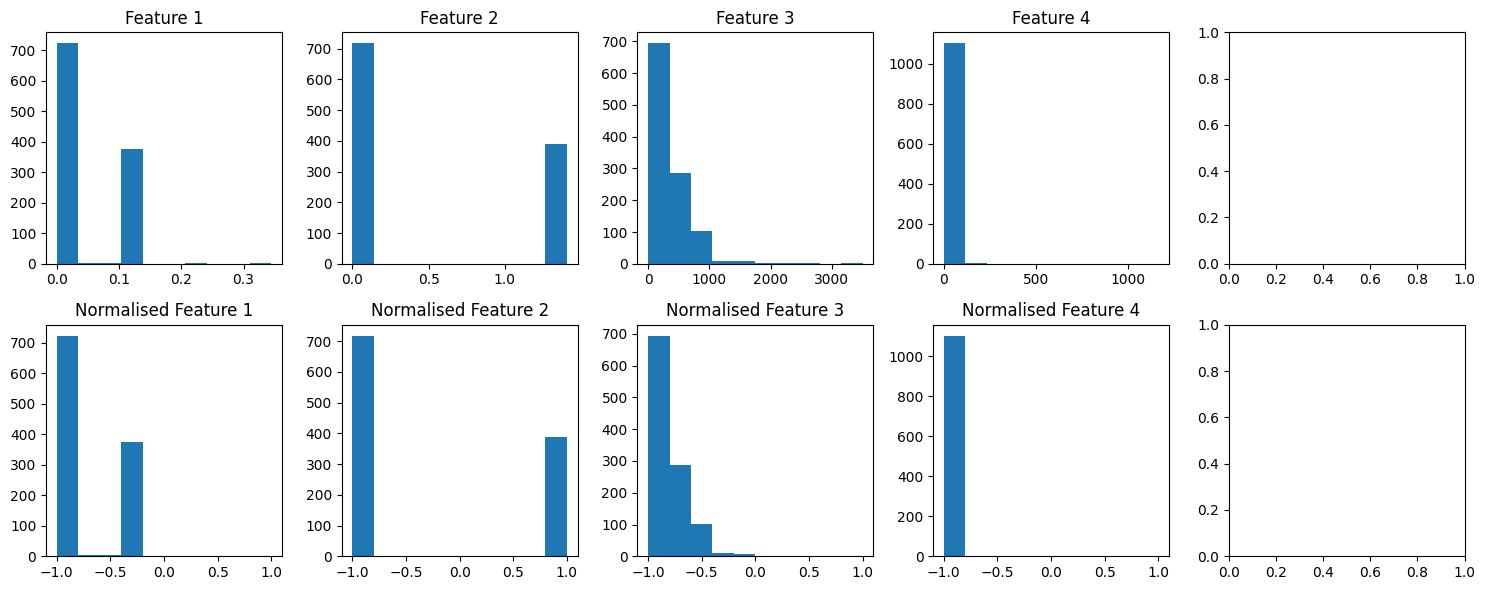

In [44]:
import matplotlib.pyplot as plt


embeddings = food_embeddings
normalised_embeddings = rescale(food_embeddings, -1, 1)
# Create Q-Q plots for each feature
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(0,4):
    axes[0,i].hist(embeddings[:,i])
    axes[0,i].set_title(f"Feature {i+1}")
    axes[1,i].hist(normalised_embeddings[:,i])
    axes[1,i].set_title(f"Normalised Feature {i+1}")

plt.tight_layout()
plt.show()

In [45]:
food_embeddings = rescale(food_embeddings, -1, 1)

## Special Tokens

Creating special token embeddings to be initialised.

In [46]:
special_token_embeddings = np.stack([
        np.zeros((food_embeddings.shape[1])), # padding
        np.ones((food_embeddings.shape[1])), # mask
        food_embeddings[3:].mean(axis=0), # unknown
        np.random.normal(0, 1, (food_embeddings.shape[1]))] # end
)

special_token_embeddings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-0.78055802, -0.31073877, -0.83967442, ..., -0.25475975,
        -0.25475975, -0.25475975],
       [ 1.79593059,  0.19217771,  1.08732752, ..., -1.5028833 ,
        -0.39798162,  0.17064099]])

As the embedding model requires we'll have to add padding zero vectors in place of the special tokens.

In [47]:
food_embeddings = np.concatenate([
    np.zeros(special_token_embeddings.shape),
    food_embeddings
], axis=0)

## Saving

In [49]:
np.save('../../data/local/final/full/food_names/0.npy', food_names)
np.save('../../data/local/final/full/food_embeddings/0.npy', food_embeddings)
np.save('../../data/local/final/full/special_token_embeddings/0.npy', special_token_embeddings)

# Recipe Food Tokens

Here we want to format our data as food token id's for each recipe.

- Converting to numpy
- Handling NA values
- Grouping data by recipe
- Merging duplicate entries (summing quantities)

The token embeddings were added to the beginning of the embedding array, for quality of life in terms of developing the model. The downside of this is we have to shift all the food_ids up.

In [50]:
#| export
def shift_food_ids(food_ids, special_tokens):
    shift = len(special_tokens)
    return food_ids.progress_apply(lambda id: id + shift if pd.notna(id) else id)

In [51]:
food_ids['food_id'] = shift_food_ids(food_ids['food_id'], special_tokens)

100%|██████████| 2450/2450 [00:00<00:00, 1477292.24it/s]


Here we fill na's with the unknown token.

In [52]:
food_ids = food_ids.fillna(special_tokens.index('unknown'))

In [53]:
#| export
def process_food_ids(food_ids, special_tokens):
    food_ids['food_id'] = shift_food_ids(food_ids['food_id'], special_tokens)
    food_ids['food_id'] = food_ids['food_id'].map(temp_remap)
    food_ids = food_ids.fillna(special_tokens.index('unknown'))
    return food_ids

Grouping values by recipe, with food_id tokens in the columns.

In [54]:
recipe_food_ids = pd.DataFrame(food_ids.groupby('recipe')['food_id'].progress_aggregate(list).tolist()).loc[:,:20]
recipe_food_ids

100%|██████████| 302/302 [00:00<00:00, 59771.60it/s]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,975.0,831.0,808.0,809.0,813.0,777.0,273.0,811.0,813.0,724.0,...,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,807.0,777.0,831.0,2.0,1041.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,777.0,809.0,813.0,795.0,80.0,808.0,975.0,813.0,80.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,955.0,957.0,774.0,68.0,541.0,795.0,1022.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,338.0,18.0,82.0,813.0,975.0,777.0,18.0,82.0,424.0,541.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,243.0,820.0,1032.0,831.0,1071.0,12.0,84.0,80.0,60.0,60.0,...,848.0,60.0,813.0,808.0,NaN,NaN,NaN,NaN,NaN,NaN
298,1022.0,813.0,777.0,273.0,975.0,893.0,68.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,426.0,1071.0,80.0,168.0,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,1071.0,12.0,676.0,80.0,344.0,1105.0,179.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
recipe = recipe_food_ids.iloc[0]
recipe[recipe.duplicated()] = pd.NA
recipe.dropna().reset_index(drop=True)


0      975.0
1      831.0
2      808.0
3      809.0
4      813.0
5      777.0
6      273.0
7      811.0
8      724.0
9     1041.0
10     139.0
Name: 0, dtype: float64

In [56]:
#| export
def remove_duplicate_ids(recipe, max_length):
    base = pd.Series(pd.NA, index=range(0,max_length), dtype='Int64')
    recipe_clone = recipe.copy(deep=True)
    recipe_clone[recipe_clone.duplicated()] = pd.NA
    recipe_clone = recipe_clone.dropna().reset_index(drop=True)
    base = base.fillna(recipe_clone)
    return base

In [57]:
from recipe_dataset.utils.parallel import parallel_apply

parallel_apply(recipe_food_ids,
               remove_duplicate_ids,
               args=(17,),
               meta=pd.DataFrame(dtype="Int64", columns=range(0,17)))

[11/04/2024 20:05:10] [INFO] [recipe_dataset.utils.parallel] [parallel_apply():47] [PID:32586 TID:139783527080768] Commencing parallel apply
[11/04/2024 20:05:10] [INFO] [recipe_dataset.utils.parallel] [parallel_apply():48] [PID:32586 TID:139783527080768] DF shape: (302, 21) | DF size: 49.55 KB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,975,831,808,809,813,777,273,811,724,1041,139,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,807,777,831,2,1041,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,777,809,813,795,80,808,975,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,955,957,774,68,541,795,1022,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,338,18,82,813,975,777,424,541,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,243,820,1032,831,1071,12,84,80,60,92,848,813,808,<NA>,<NA>,<NA>,<NA>
298,1022,813,777,273,975,893,68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
299,426,1071,80,168,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
300,1071,12,676,80,344,1105,179,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [58]:
recipe_food_ids = recipe_food_ids.progress_apply(remove_duplicate_ids, axis=1, args=(17,))
recipe_food_ids

100%|██████████| 302/302 [00:00<00:00, 2229.16it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,975,831,808,809,813,777,273,811,724,1041,139,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,807,777,831,2,1041,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,777,809,813,795,80,808,975,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,955,957,774,68,541,795,1022,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,338,18,82,813,975,777,424,541,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,243,820,1032,831,1071,12,84,80,60,92,848,813,808,<NA>,<NA>,<NA>,<NA>
298,1022,813,777,273,975,893,68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
299,426,1071,80,168,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
300,1071,12,676,80,344,1105,179,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#TODO: Decide on optimal reicpe size

The NA values here are those where the recipe didn't have enough foods to fill the columns, so these can be filled with padding values.

In [59]:
recipe_food_ids = recipe_food_ids \
    .fillna(special_tokens.index('pad')) \
    .astype('int') \
    .to_numpy()

recipe_food_ids, recipe_food_ids.shape

(array([[ 975,  831,  808, ...,    0,    0,    0],
        [ 807,  777,  831, ...,    0,    0,    0],
        [ 777,  809,  813, ...,    0,    0,    0],
        ...,
        [ 426, 1071,   80, ...,    0,    0,    0],
        [1071,   12,  676, ...,    0,    0,    0],
        [1048, 1032,   60, ...,    0,    0,    0]]),
 (302, 17))

In [60]:
#| export
def compile_recipe_food_ids(food_ids, special_tokens):

    print('Compiling recipe food ids')
    recipe_food_ids = pd.DataFrame(food_ids.groupby('recipe')['food_id'].progress_aggregate(list).tolist()).loc[:,:25]

    print('Removing duplicates')
    recipe_food_ids = parallel_apply(recipe_food_ids,
               remove_duplicate_ids,
               args=(17,),
               meta=pd.DataFrame(dtype="Int64", columns=range(0,17)),
               npartitions=1000)

    print('Formatting')
    recipe_food_ids = recipe_food_ids \
        .fillna(special_tokens.index('pad')) \
        .astype('int') \
        .to_numpy()

    return recipe_food_ids

## Saving

In [61]:
np.save('../../data/local/final/partial/recipe_food_ids/0.npy', recipe_food_ids)

In [56]:
from nbdev import nbdev_export; nbdev_export()